In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

paths = list()
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path)
        print(path)

/kaggle/input/char-one-hot-enc/__results__.html
/kaggle/input/char-one-hot-enc/checkpoint.data-00000-of-00001
/kaggle/input/char-one-hot-enc/checkpoint.index
/kaggle/input/char-one-hot-enc/__notebook__.ipynb
/kaggle/input/char-one-hot-enc/__output__.json
/kaggle/input/char-one-hot-enc/checkpoint
/kaggle/input/char-one-hot-enc/custom.css
/kaggle/input/uplift-shift-23/baseline.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv
/kaggle/input/data-preparation/__results__.html
/kaggle/input/data-preparation/__notebook__.ipynb
/kaggle/input/data-preparation/purches_v4.csv
/kaggle/input/data-preparation/__output__.json
/kaggle/input/data-preparation/c

In [2]:
%%time
purches = pd.read_csv('/kaggle/input/data-preparation/purches_v4.csv', header=None, index_col=1).drop(0, axis=1)
purches.index.rename('client_id', inplace=True)

CPU times: user 6.2 s, sys: 1.21 s, total: 7.41 s
Wall time: 11.2 s


In [3]:
train_clients = pd.read_csv(f'/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv').set_index('client_id').sort_index()
test_clients = pd.read_csv(f'/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv').set_index('client_id').sort_index()

In [4]:
# заводим столбец с окончательной целевой разметкой
train_markup = train_clients.apply(lambda df: int(df['treatment_flg'] == df['purchased']), axis=1)
# train_markup = train_clients.apply(lambda df: str(df['treatment_flg']) + str(df['purchased']), axis=1)
# train_markup = pd.get_dummies(train_markup)
# train_markup['01'] = train_markup.apply(lambda df: df['01'] + df['10'], axis=1)
# train_markup.drop('10', axis=1, inplace=True)

In [5]:
# создаем соотвествуеющие ей входные данные
train = purches.loc[train_clients.index]
test = purches.loc[test_clients.index]

In [6]:
# нормируем все данные по всем клиентам (и тестовым, и тренировочным)
scaler = StandardScaler().fit(purches)
X = scaler.transform(train)
y = train_markup

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def getModel(num_of_dims):
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=num_of_dims))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [37]:
model = getModel(num_of_dims=X.shape[1])
history = model.fit(X, y, validation_split=0.10, epochs=15, batch_size=32).history

Epoch 1/15
3939/3939 [==============================] - 17s 4ms/step - loss: 0.6967 - accuracy: 0.5101 - auc: 0.5028 - val_loss: 0.6925 - val_accuracy: 0.5179 - val_auc: 0.5066
Epoch 2/15
3939/3939 [==============================] - 16s 4ms/step - loss: 0.6929 - accuracy: 0.5144 - auc: 0.5118 - val_loss: 0.6921 - val_accuracy: 0.5215 - val_auc: 0.5084
Epoch 3/15
3939/3939 [==============================] - 16s 4ms/step - loss: 0.6927 - accuracy: 0.5140 - auc: 0.5124 - val_loss: 0.6924 - val_accuracy: 0.5212 - val_auc: 0.5021
Epoch 4/15
3939/3939 [==============================] - 16s 4ms/step - loss: 0.6922 - accuracy: 0.5148 - auc: 0.5190 - val_loss: 0.6926 - val_accuracy: 0.5224 - val_auc: 0.5040
Epoch 5/15
3939/3939 [==============================] - 15s 4ms/step - loss: 0.6913 - accuracy: 0.5206 - auc: 0.5250 - val_loss: 0.6926 - val_accuracy: 0.5187 - val_auc: 0.5024
Epoch 6/15
3939/3939 [==============================] - 16s 4ms/step - loss: 0.6898 - accuracy: 0.5252 - auc: 0.536

In [34]:
test_pred = model.predict(scaler.transform(test))

In [35]:
pd.DataFrame(test_pred).set_index(test.index).rename(columns={0: 'pred'}).to_csv('/kaggle/working/test_pred_v4.4.csv')

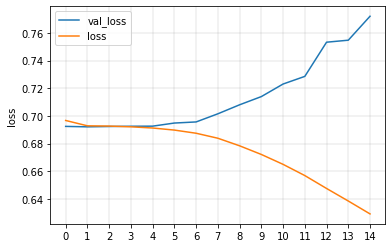

In [38]:
epochs = [i for i in range(15)]
plt.grid(True, color='#090909', linewidth=0.1)
plt.plot(epochs, history['val_loss'], label='val_loss')
plt.plot(epochs, history['loss'], label='loss')

plt.ylabel('loss')
plt.xticks(epochs)
plt.legend()
plt.show()

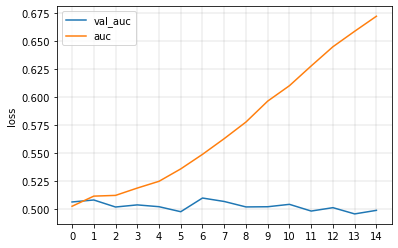

In [39]:
epochs = [i for i in range(15)]
plt.grid(True, color='#090909', linewidth=0.1)
plt.plot(epochs, history['val_auc'], label='val_auc')
plt.plot(epochs, history['auc'], label='auc')

plt.ylabel('loss')
plt.xticks(epochs)
plt.legend()
plt.show()

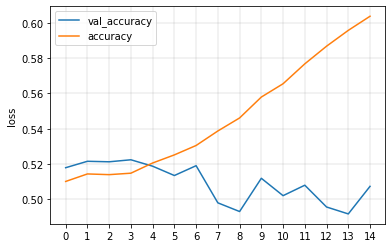

In [40]:
epochs = [i for i in range(15)]
plt.grid(True, color='#090909', linewidth=0.1)
plt.plot(epochs, history['val_accuracy'], label='val_accuracy')
plt.plot(epochs, history['accuracy'], label='accuracy')

plt.ylabel('loss')
plt.xticks(epochs)
plt.legend()
plt.show()

In [20]:
%%time
# 7min 44s
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, y_train = X, y

models = (('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()), 
          ('LogisticRegression', LogisticRegression()),
          ('DecisionTreeClassifier', DecisionTreeClassifier()),
          ('GaussianNB', GaussianNB()),
          # ('RandomForestClassifier', RandomForestClassifier()),
          # ('KNeighborsClassifier', KNeighborsClassifier()),
          # ('C-SVM', SVC(random_state=42)),
         )

print(f' train_acc \t val_acc\t time \t\tmodel')
print(f'{y_train.sum()/len(y_train): .4}\t\t{y_val.sum()/len(y_val): .4}\t\t\t\tbaseline')

for model_name, model in models: 
    # break # чтобы не тратить время при запуске
    
    t0 = time()
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_accuracy = metrics.accuracy_score(y_train, train_pred)
    val_accuracy = metrics.accuracy_score(y_val, val_pred)

    print(f'{train_accuracy: .4}\t\t{val_accuracy: .4}\t\t{time() - t0: .3} \t\t{model_name}')
    
    #  train_acc     val_acc     time      model
    #  0.5189        0.512                 baseline
    #  0.5246        0.5092      2.62      LinearDiscriminantAnalysis
    #  0.5245        0.5091      2.66      LogisticRegression
    #  1.0           0.5041      29.0      DecisionTreeClassifier
    #  0.4921        0.4955      0.404     GaussianNB
    #  1.0           0.5083      139.0     RandomForestClassifier
    #  0.6889        0.5032      291.2     KNeighborsClassifier

 train_acc 	 val_acc	 time 		model
 0.5169		 0.512				baseline
 0.5162		 0.5127		 0.425 		LinearDiscriminantAnalysis
 0.5162		 0.5125		 0.606 		LogisticRegression
 1.0		 1.0		 13.7 		DecisionTreeClassifier
 0.5147		 0.5116		 0.128 		GaussianNB
CPU times: user 15.7 s, sys: 1.45 s, total: 17.2 s
Wall time: 14.9 s


In [41]:
%%time
from sklearn.manifold import TSNE
import seaborn as sns
tsne_result = TSNE().fit_transform(X[:30000])

CPU times: user 14min 28s, sys: 8.46 s, total: 14min 36s
Wall time: 4min 21s


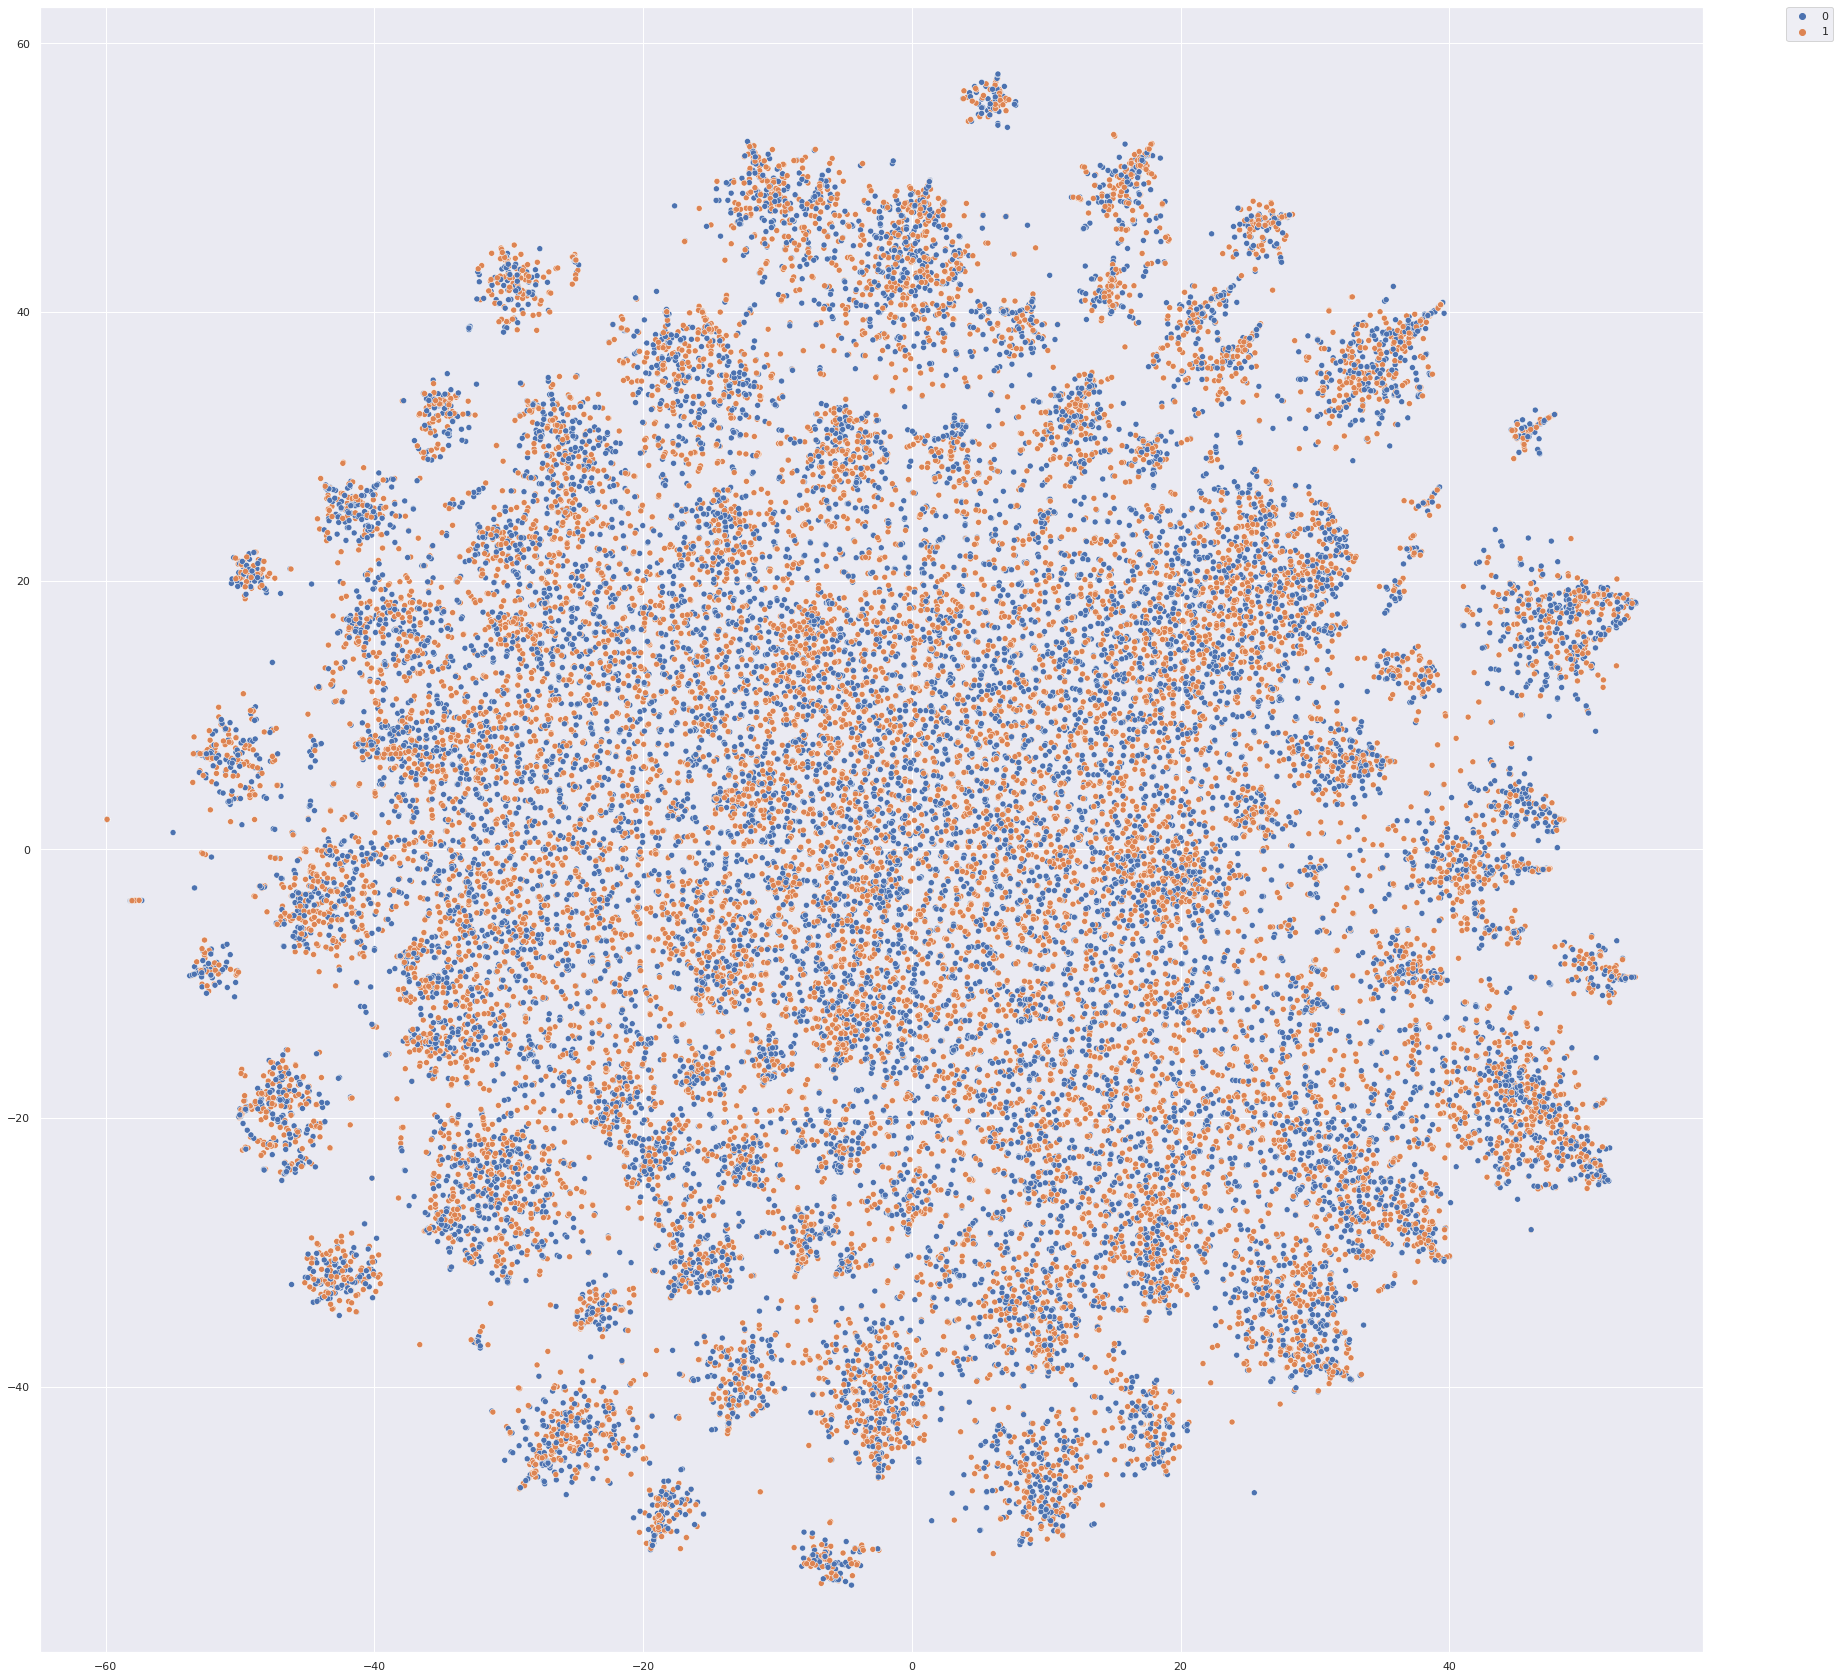

In [44]:
# sns.rcParams['figure.figsize'] = 11.7,8.27
tsne_result_df = pd.DataFrame({'x': tsne_result[:,0], 'y': tsne_result[:,1], 'label': y[:30000]})
fig, ax = plt.subplots(1)
sns.set(rc={'figure.figsize':(40.7,30.27)})
sns.scatterplot(x='x', y='y', hue='label', data=tsne_result_df, ax=ax) # s=120
ax.set_xlim((tsne_result[:,0].min()-5, tsne_result[:,0].max()+5))
ax.set_ylim((tsne_result[:,1].min()-5, tsne_result[:,1].max()+5))
ax.set_aspect('equal')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)